Initial test of Avito dataset. Used the following features:
1. parentCategoryID_x
2. price_diff : Log of the absolute difference in prices between itemID_1 and itemID_2.
3. title_desc_xy : Title and description of itemID_1 and itemID_2 concatenated together.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.similarities.docsim import Similarity
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold

In [24]:
iteminfo_train = pd.read_csv('ItemInfo_train.csv')
#iteminfo_test = pd.read_csv('ItemInfo_test.csv')

In [25]:
itempairs_train = pd.read_csv('ItemPairs_train.csv')
#itempairs_test = pd.read_csv('ItemPairs_test.csv')

In [26]:
location = pd.read_csv('Location.csv')
category = pd.read_csv('Category.csv')

In [27]:
itempairs_train.count()

itemID_1            2991396
itemID_2            2991396
isDuplicate         2991396
generationMethod    2991396
dtype: int64

In [28]:
iteminfo_train.count()

itemID          3344613
categoryID      3344613
title           3344612
description     3344508
images_array    2946588
attrsJSON       3240625
price           3022487
locationID      3344613
metroID         1100795
lat             3344613
lon             3344613
dtype: int64

In [29]:
category.count()

categoryID          51
parentCategoryID    51
dtype: int64

In [30]:
print 'Length of ItemPairs_train.csv ' + str(len(itempairs_train))
print 'Length of ItemInfo_train.csv ' + str(len(iteminfo_train))
print 'Length of Location.csv ' + str(len(location))
print 'Length of Category.csv ' + str(len(category))

Length of ItemPairs_train.csv 2991396
Length of ItemInfo_train.csv 3344613
Length of Location.csv 3449
Length of Category.csv 51


In [31]:
print 'itempairs_train dataframe'
print itempairs_train.head()
print '\n\nitemInfo_train dataframe'
print iteminfo_train.head()
print '\n\nlocation dataframe'
print location.head()
print '\n\nitemPairs_train counts'
print itempairs_train.count()
print '\n\nlocation counts'
print location.count()
print '\n\niteminfo_train counts'
print iteminfo_train.count()

itempairs_train dataframe
   itemID_1  itemID_2  isDuplicate  generationMethod
0         1   4112648            1                 1
1         3   1991275            1                 1
2         4   1223296            0                 1
3         7   1058851            1                 1
4         8   2161930            1                 1


itemInfo_train dataframe
   itemID  categoryID                                title  \
0       1          81                    Продам Камаз 6520   
1       3          14                            Yamaha r6   
2       4          84                       iPhone 3gs 8gb   
3       7          84  Xiaomi Mi4 3гб RAM + 16гб ROM белый   
4       8          39                       Лыжные ботинки   

                                         description  \
0                          Продам Камаз 6520 20 тонн   
1                                    Весь в тюнинге.   
2  Телефон в хорошем состоянии, трещин и сколов н...   
3  Отличный подарок на новый год

In [32]:
iteminfo_train_loc = pd.merge(pd.merge(iteminfo_train, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')
#iteminfo_test_loc = pd.merge(pd.merge(iteminfo_test, location, how = 'left', on = 'locationID'), category, how = 'left', on = 'categoryID')

In [33]:
x = pd.merge(pd.merge(itempairs_train, iteminfo_train_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
                    iteminfo_train_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')
#x_test = pd.merge(pd.merge(itempairs_test, iteminfo_test_loc, how = 'left', left_on = 'itemID_1', right_on = 'itemID'), 
#                    iteminfo_test_loc, how = 'left', left_on = 'itemID_2', right_on = 'itemID')

In [34]:
x.count()

itemID_1              2991396
itemID_2              2991396
isDuplicate           2991396
generationMethod      2991396
itemID_x              2991396
categoryID_x          2991396
title_x               2991395
description_x         2991344
images_array_x        2713476
attrsJSON_x           2885530
price_x               2707502
locationID_x          2991396
metroID_x             1015627
lat_x                 2991396
lon_x                 2991396
regionID_x            2991396
parentCategoryID_x    2991396
itemID_y              2991396
categoryID_y          2991396
title_y               2991396
description_y         2991335
images_array_y        2712759
attrsJSON_y           2885530
price_y               2707165
locationID_y          2991396
metroID_y             1015224
lat_y                 2991396
lon_y                 2991396
regionID_y            2991396
parentCategoryID_y    2991396
dtype: int64

## Category

In [35]:
x['same_cat'] = np.where(x.categoryID_x == x.categoryID_y, True, False)
print x.groupby('same_cat').count()['itemID_1']

same_cat
True    2991396
Name: itemID_1, dtype: int64


In [36]:
x['same_par_cat'] = np.where(x.parentCategoryID_x == x.parentCategoryID_y, True, False)
x.groupby('same_par_cat').count()['itemID_1']

same_par_cat
True    2991396
Name: itemID_1, dtype: int64

Since both items are sampled from the same category, we can drop one of the category columns.

## Price

Create a new variable price_diff:
$$price\_diff = \log(\lvert x.price\_x - x.price\_y\rvert)$$
where NaN values are currently left as zeros.

In [37]:
x['price_diff'] = abs(x.price_x - x.price_y).map(lambda x : 0 if np.isnan(x) else 0 if x == 0 else math.log(x))
#x_test['price_diff'] = abs(x_test.price_x - x_test.price_y).map(lambda x : 0 if np.isnan(x) else 0 if x == 0 else math.log(x))

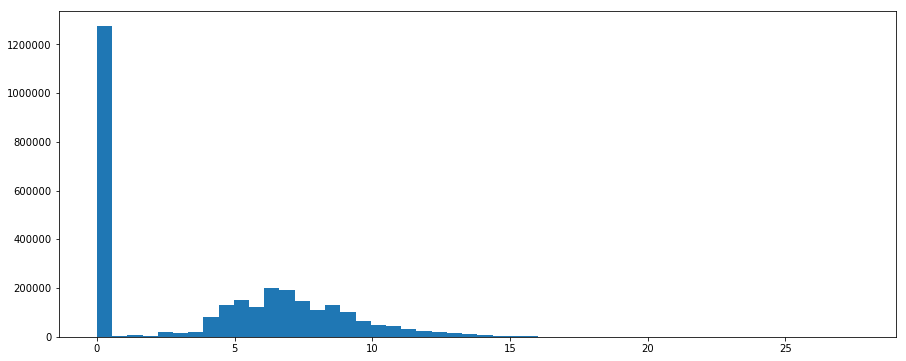

In [38]:
figure = plt.figure(figsize=(15,6))
plt.hist(x.price_diff, bins = 50)
plt.show()

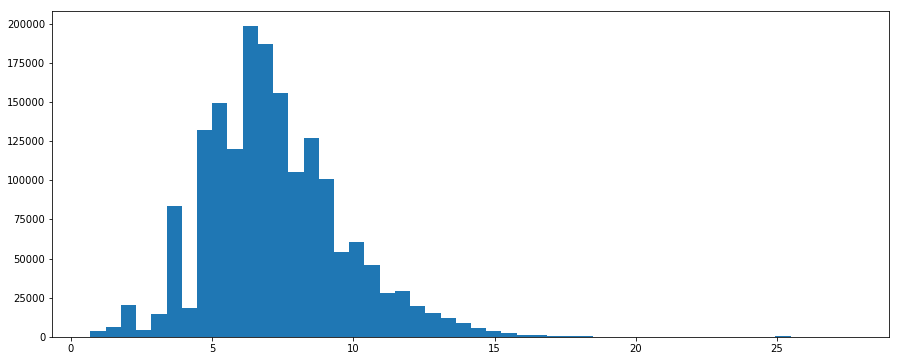

In [39]:
figure = plt.figure(figsize=(15,6))
plt.hist(np.array(x.price_diff)[np.where(x.price_diff != 0)], bins = 50)
plt.show()

## Title and Description
Combine both columns and transform into document term matrix

In [40]:
x['title_x'] = x.title_x.map(lambda x : '' if pd.isnull(x) else x)
x['title_y'] = x.title_y.map(lambda x : '' if pd.isnull(x) else x)
x['description_x'] = x.description_x.map(lambda x : '' if pd.isnull(x) else x)
x['description_y'] = x.description_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_x'] = x_test.title_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['title_y'] = x_test.title_y.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_x'] = x_test.description_x.map(lambda x : '' if pd.isnull(x) else x)
#x_test['description_y'] = x_test.description_

x['title_desc_x'] = x.title_x + x.description_x
x['title_desc_y'] = x.title_y + x.description_y
#x_test['title_desc_x'] = x_test.title_x + x_test.description_x
#x_test['title_desc_y'] = x_test.title_y + x_test.description_y

x['title_desc_xy'] = x.title_desc_x + x.title_desc_y

In [41]:
del x['itemID_1']
del x['itemID_2']
del x['itemID_x']
del x['itemID_y']
del x['categoryID_x']
del x['categoryID_y']
del x['parentCategoryID_y']
del x['images_array_x']
del x['images_array_y']
del x['attrsJSON_x']
del x['attrsJSON_y']
del x['price_x']
del x['price_y']
del x['locationID_x']
del x['locationID_y']
del x['metroID_x']
del x['metroID_y']
del x['lat_x']
del x['lat_y']
del x['lon_x']
del x['lon_y']
del x['regionID_x']
del x['regionID_y']
del x['same_cat']
del x['generationMethod']
del x['title_x']
del x['title_y']
del x['description_x']
del x['description_y']
del x['title_desc_x']
del x['title_desc_y']

In [42]:
x.count()

isDuplicate           2991396
parentCategoryID_x    2991396
same_par_cat          2991396
price_diff            2991396
title_desc_xy         2991396
dtype: int64

In [43]:
class parCatIDTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return pd.DataFrame(X.parentCategoryID_x)

    def fit(self, X, y=None, **fit_params):
        return self
    
class priceDiffTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return pd.DataFrame(X.price_diff, columns = ['price_diff'])

    def fit(self, X, y=None, **fit_params):
        return self
    
class ContentTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return X.title_desc_xy

    def fit(self, X, y=None, **fit_params):
        return self

In [44]:
count_vect = CountVectorizer()
log_reg = LogisticRegression()

In [45]:
pipe_log = Pipeline([
    ('features', FeatureUnion([
        ('pipe_cont', Pipeline([
            ('content', ContentTransformer()),
            ('count_vect', CountVectorizer(ngram_range = (1, 2)))
        ])),
        ('price_diff', priceDiffTransformer()), 
        ('parentCategoryID_x', parCatIDTransformer())
    ])),
    ('log_reg', log_reg)])

K-Fold CV to check validation and train accuracy

In [46]:
kf = KFold(n_splits = 5, random_state = 1)
train_score = []
test_score = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x.loc[train_index, :], x.loc[test_index, :]
    pipe_log.fit(x_train.iloc[:, x_train.columns != 'isDuplicate'], x_train.isDuplicate)
    pred_train = pipe_log.predict(x_train)
    pred_test = pipe_log.predict(x_test)
    train_score.append(pred_train)
    test_score.append(pred_test)
    print "Test Accuracy:", accuracy_score(x_test.isDuplicate, pred_test)
    print "Train Accuracy:", accuracy_score(x_train.isDuplicate, pred_train)

Test Accuracy: 0.787405562613
Train Accuracy: 0.812376416354
Test Accuracy: 0.787931717476
Train Accuracy: 0.809591841937
Test Accuracy: 0.791264610658
Train Accuracy: 0.810602657538
Test Accuracy: 0.787273161853
Train Accuracy: 0.805328782504
Test Accuracy: 0.789910727269
Train Accuracy: 0.806805935523
